In [1]:
print("Hello, World! How are you all doing today?")
print("I am doing well, thank you for asking.")

Hello, World! How are you all doing today?
I am doing well, thank you for asking.


In [2]:
"""

This module performs an in-depth exploratory data analysis (EDA) on the Capital Bikeshare hourly dataset
and builds a RandomForestRegressor model to predict hourly bike utilization. The code is organized into
modular functions with unit tests for critical components.

Dataset Details:
- hour.csv contains 17,379 records with hourly aggregated bike rental counts.
- Data includes temporal, weather, and seasonal features.

"""

import os
import unittest
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')


In [3]:
def load_data(filepath: str) -> pd.DataFrame:
    """
    Load the CSV data file into a pandas DataFrame.
    
    Parameters:
        filepath (str): The path to the CSV file.
        
    Returns:
        pd.DataFrame: The loaded dataset.
    """
    try:
        data = pd.read_csv(filepath)
        logging.info("Data loaded successfully from %s", filepath)
        return data
    except Exception as e:
        logging.error("Failed to load data: %s", e)
        raise


In [4]:
def perform_eda(data: pd.DataFrame, output_dir: str = "plots") -> None:
    """
    Conduct Exploratory Data Analysis (EDA) on the dataset and save plots to the specified output directory.
    
    Parameters:
        data (pd.DataFrame): The dataset for analysis.
        output_dir (str): Directory where plots will be saved.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Distribution of total counts (cnt)
    plt.figure(figsize=(8, 5))
    sns.histplot(data['cnt'], kde=True, bins=50)
    plt.title('Distribution of Total Bike Rental Count')
    plt.xlabel('Total Count (cnt)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cnt_distribution.png'))
    plt.show()
    plt.close()
    
    # Time-series plot: average count by hour of day
    plt.figure(figsize=(8, 5))
    hourly_avg = data.groupby('hr')['cnt'].mean().reset_index()
    sns.lineplot(x='hr', y='cnt', data=hourly_avg, marker='o')
    plt.title('Average Bike Rentals by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'hourly_avg.png'))
    plt.show()
    # plt.close()
    
    # Box plot by weather situation
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='weathersit', y='cnt', data=data)
    plt.title('Bike Rentals by Weather Situation')
    plt.xlabel('Weather Situation')
    plt.ylabel('Total Count (cnt)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cnt_by_weathersit.png'))
    plt.show()
    plt.close()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    corr = data[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
    plt.show()
    plt.close()
    
    logging.info("EDA plots saved in the '%s' directory.", output_dir)


In [5]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataset by selecting features and handling any necessary transformations.
    
    Parameters:
        data (pd.DataFrame): The raw dataset.
        
    Returns:
        pd.DataFrame: The preprocessed dataset ready for model training.
    """
    # Drop columns that are not used in prediction
    features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
    target = 'cnt'
    
    # Additional transformations can be added here (e.g., one-hot encoding categorical variables)
    df = data[features + [target]].copy()
    
    # Convert categorical features to type 'category'
    categorical_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
    for col in categorical_cols:
        df[col] = df[col].astype('category')
    
    logging.info("Data preprocessing completed.")
    return df


In [6]:
def train_model(data: pd.DataFrame, random_state: int = 42) -> (RandomForestRegressor, float):
    """
    Train a RandomForestRegressor model to predict hourly bike utilization.
    
    Parameters:
        data (pd.DataFrame): The preprocessed dataset.
        random_state (int): Seed for reproducibility.
    
    Returns:
        model (RandomForestRegressor): The trained model.
        mad (float): Mean Absolute Deviation on the test set.
    """
    # Separate features and target
    X = data.drop(columns='cnt')
    y = data['cnt']
    
    # For simplicity, perform a train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # One-hot encode categorical features
    X_train_enc = pd.get_dummies(X_train, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, drop_first=True)

    model_columns = X_train_enc.columns
    # Align columns in case of missing dummy variables in test set
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    model.fit(X_train_enc, y_train)
    
    predictions = model.predict(X_test_enc)
    mad = mean_absolute_error(y_test, predictions)
    
    logging.info("Model trained successfully. MAD: %.2f", mad)
    return model, mad, model_columns

In [7]:
# --- Unit Tests ---
class TestBikeSharingAnalysis(unittest.TestCase):
    """Unit tests for key functions in the bike sharing analysis module."""
    
    def setUp(self):
        # Create a small sample dataframe for testing
        self.sample_data = pd.DataFrame({
            'season': [1, 2],
            'yr': [0, 1],
            'mnth': [1, 2],
            'hr': [0, 1],
            'holiday': [0, 1],
            'weekday': [1, 2],
            'workingday': [1, 0],
            'weathersit': [1, 2],
            'temp': [0.5, 0.7],
            'atemp': [0.4, 0.6],
            'hum': [0.8, 0.9],
            'windspeed': [0.1, 0.2],
            'cnt': [100, 150]
        })
    
    def test_preprocess_data(self):
        processed = preprocess_data(self.sample_data)
        # Check if all expected columns are present
        expected_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
                         'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
        self.assertTrue(all(col in processed.columns for col in expected_cols))
        # Check type conversion
        self.assertTrue(pd.api.types.is_categorical_dtype(processed['season']))
    
    def test_load_data_failure(self):
        with self.assertRaises(Exception):
            # Attempt to load a non-existent file
            load_data("non_existent_file.csv")


In [10]:
def main():
    # File path configuration (adjust the path as needed)
    data_filepath = "../../data/hour.csv"  # Ensure this file is in your working directory
    
    # Load the dataset
    data = load_data(data_filepath)
    
    # Conduct EDA and save plots
    perform_eda(data, output_dir="plots")
    
    # Preprocess the data
    processed_data = preprocess_data(data)
    
    # Train the prediction model and evaluate using MAD
    model, mad, model_columns = train_model(processed_data)
    
    
    # Print final evaluation metric
    print(f"Mean Absolute Deviation (MAD) of the model: {mad:.2f}")
    
    # (Optional) Save the trained model if needed for production use.
    # For example: using joblib: joblib.dump(model, 'bike_model.pkl')
    return model, model_columns


2025-03-26 09:36:07,036 [ERROR] Failed to load data: [Errno 2] No such file or directory: 'non_existent_file.csv'
.2025-03-26 09:36:07,039 [INFO] Data preprocessing completed.
/var/folders/t2/55vgl7rd2pd84zg2rhmyz6ww0000gn/T/ipykernel_92158/68418159.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  self.assertTrue(pd.api.types.is_categorical_dtype(processed['season']))
.
----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK
2025-03-26 09:36:07,051 [INFO] Data loaded successfully from ../../data/hour.csv


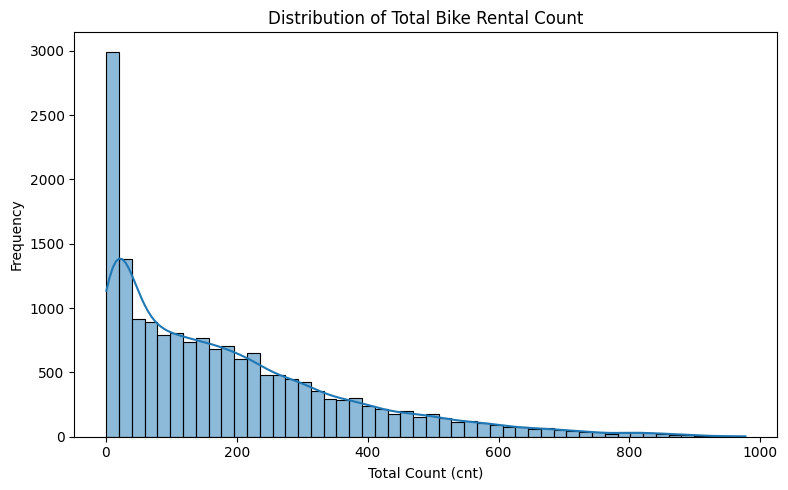

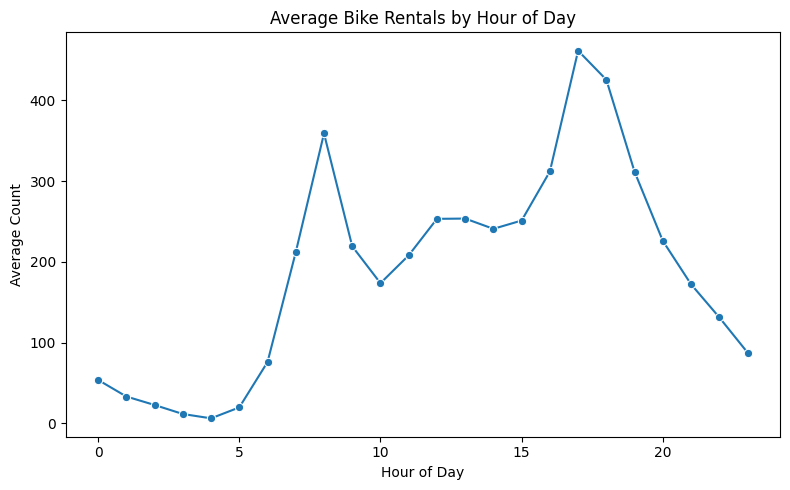

2025-03-26 09:36:07,223 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-26 09:36:07,227 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


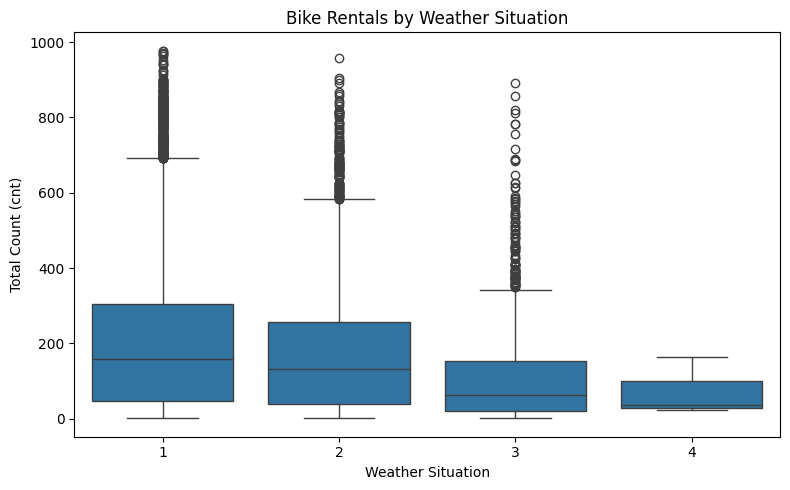

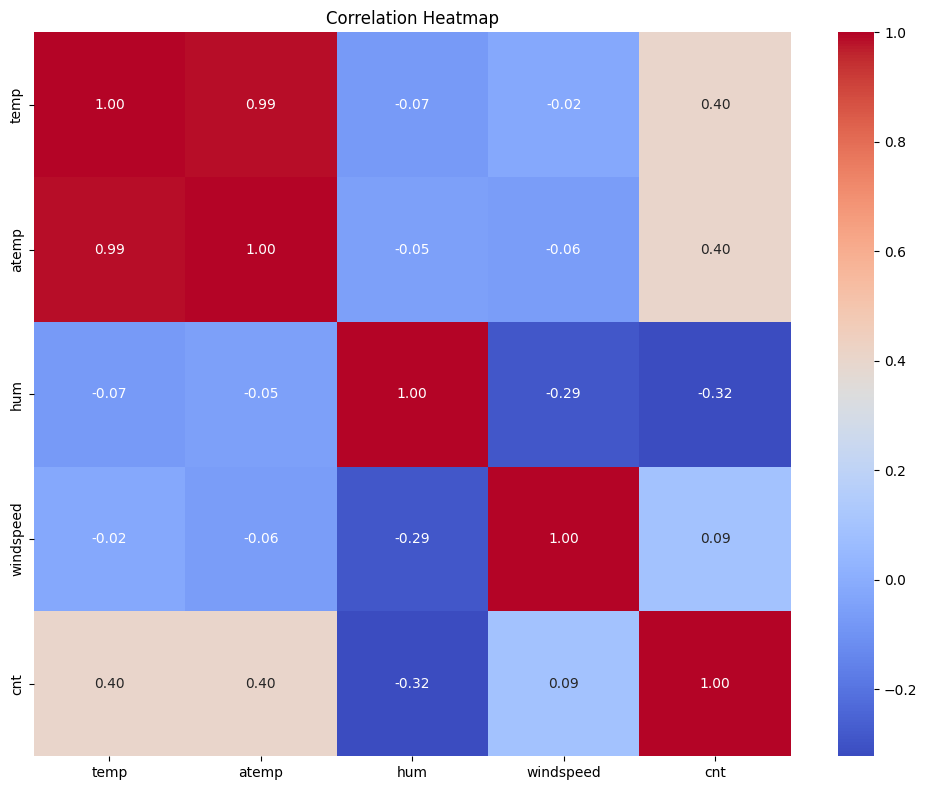

2025-03-26 09:36:07,358 [INFO] EDA plots saved in the 'plots' directory.
2025-03-26 09:36:07,360 [INFO] Data preprocessing completed.
2025-03-26 09:36:11,064 [INFO] Model trained successfully. MAD: 32.86


Mean Absolute Deviation (MAD) of the model: 32.86


In [11]:
if __name__ == "__main__":
    # Run unit tests
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
    
    # Run main analysis
    model, model_columns = main()

In [12]:
import pandas as pd

# Example new data point (you can also load from a CSV or another source)
# instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
new_data = {
    'season': [1],
    'yr': [1],
    'mnth': [3],
    'hr': [10],
    'holiday': [0],
    'weekday': [2],
    'workingday': [1],
    'weathersit': [1],
    'temp': [0.6],
    'atemp': [0.65],
    'hum': [0.45],
    'windspeed': [0.1]
}

# Create DataFrame from the new data
df_new = pd.DataFrame(new_data)

# Convert categorical features to the appropriate type
categorical_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
for col in categorical_cols:
    df_new[col] = df_new[col].astype('category')

# One-hot encode new data (using drop_first=True as in training)
df_new_enc = pd.get_dummies(df_new, drop_first=True)

# Suppose during training you saved the training feature columns as 'model_columns'
# For example, right after training you could store them:
# model_columns = X_train_enc.columns
# For this snippet, we assume 'model_columns' is available.
# Align new data columns with training data columns
df_new_enc = df_new_enc.reindex(columns=model_columns, fill_value=0)

# Make prediction using the trained model
prediction = model.predict(df_new_enc)
print("Predicted bike rental count:", prediction[0])


Predicted bike rental count: 380.56


In [13]:
# Model Comparison file

"""
bike_sharing_model_comparison.py

This module performs data preprocessing, trains several regression models 
(RandomForest, Linear Regression, Gradient Boosting, SVR) on the Capital Bikeshare hourly dataset,
and compares their performance using Mean Absolute Deviation (MAD).

"""

import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

def load_data(filepath: str) -> pd.DataFrame:
    """
    Load the CSV data file into a pandas DataFrame.
    """
    try:
        data = pd.read_csv(filepath)
        logging.info("Data loaded successfully from %s", filepath)
        return data
    except Exception as e:
        logging.error("Failed to load data: %s", e)
        raise

def perform_eda(data: pd.DataFrame, output_dir: str = "plots") -> None:
    """
    Conduct Exploratory Data Analysis (EDA) and save plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Distribution of total counts (cnt)
    plt.figure(figsize=(8, 5))
    sns.histplot(data['cnt'], kde=True, bins=50)
    plt.title('Distribution of Total Bike Rental Count')
    plt.xlabel('Total Count (cnt)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cnt_distribution.png'))
    plt.close()
    
    # Time-series plot: average count by hour
    plt.figure(figsize=(8, 5))
    hourly_avg = data.groupby('hr')['cnt'].mean().reset_index()
    sns.lineplot(x='hr', y='cnt', data=hourly_avg, marker='o')
    plt.title('Average Bike Rentals by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'hourly_avg.png'))
    plt.close()
    
    # Box plot by weather situation
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='weathersit', y='cnt', data=data)
    plt.title('Bike Rentals by Weather Situation')
    plt.xlabel('Weather Situation')
    plt.ylabel('Total Count (cnt)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cnt_by_weathersit.png'))
    plt.close()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    corr = data[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
    plt.close()
    
    logging.info("EDA plots saved in the '%s' directory.", output_dir)

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataset by selecting features and handling necessary transformations.
    Excludes 'dteday', 'casual', and 'registered' to avoid target leakage and redundant information.
    """
    features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 
                'temp', 'atemp', 'hum', 'windspeed']
    target = 'cnt'
    
    df = data[features + [target]].copy()
    
    # Convert categorical features to type 'category'
    categorical_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
    for col in categorical_cols:
        df[col] = df[col].astype('category')
    
    logging.info("Data preprocessing completed.")
    return df

def train_and_evaluate_models(data: pd.DataFrame, random_state: int = 42) -> dict:
    """
    Train multiple regression models and evaluate them using Mean Absolute Deviation (MAD).
    
    Returns a dictionary with model names and their corresponding MAD.
    """
    # Separate features and target
    X = data.drop(columns='cnt')
    y = data['cnt']
    
    # One-hot encode categorical variables (drop_first to avoid dummy variable trap)
    X = pd.get_dummies(X, drop_first=True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Define models to compare
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=random_state),
        'LinearRegression': LinearRegression(),
        'GradientBoosting': GradientBoostingRegressor(random_state=random_state),
        'SVR': SVR()
    }
    
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mad = mean_absolute_error(y_test, predictions)
        results[name] = mad
        logging.info("%s model trained successfully. MAD: %.2f", name, mad)
    
    return results

def main():
    # File path configuration
    data_filepath = "../../data/hour.csv"  # Ensure this file is in your working directory
    
    # Load data
    data = load_data(data_filepath)
    
    # Perform EDA
    perform_eda(data, output_dir="plots")
    
    # Preprocess data
    processed_data = preprocess_data(data)
    
    # Train and evaluate models
    results = train_and_evaluate_models(processed_data)
    
    # Print evaluation results for all models
    print("Model Performance (MAD):")
    for model_name, mad in results.items():
        print(f"{model_name}: {mad:.2f}")

if __name__ == "__main__":
    main()


2025-03-26 09:36:47,067 [INFO] Data loaded successfully from ../../data/hour.csv
2025-03-26 09:36:47,165 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-26 09:36:47,170 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-26 09:36:47,253 [INFO] EDA plots saved in the 'plots' directory.
2025-03-26 09:36:47,254 [INFO] Data preprocessing completed.
2025-03-26 09:36:50,918 [INFO] RandomForest model trained successfully. MAD: 32.86
2025-03-26 09:36:50,931 [INFO] LinearRegression model trained successfully. MAD: 74.11
2025-03-26 09:36:51,694 [INFO] GradientBoosting model trained successfully. MAD: 57.03
2025-03-26 09:36:56,500 [INFO] SVR model trained successfully. MAD: 94.48


Model Performance (MAD):
RandomForest: 32.86
LinearRegression: 74.11
GradientBoosting: 57.03
SVR: 94.48


In [15]:
"""
This module provides a function to compute the average of the 'cnt' column from the bike-sharing dataset.
"""

import os
import logging
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

def get_average_cnt(filepath: str) -> float:
    """
    Calculate the average of the 'cnt' column from a CSV file.

    Parameters:
        filepath (str): Path to the CSV file.

    Returns:
        float: The average value of the 'cnt' column.
    """
    try:
        data = pd.read_csv(filepath)
        if 'cnt' not in data.columns:
            raise KeyError("Column 'cnt' not found in the dataset.")
        avg_cnt = data['cnt'].mean()
        logging.info("Computed average of 'cnt': %.2f", avg_cnt)
        return avg_cnt
    except Exception as e:
        logging.error("Error computing average of 'cnt': %s", e)
        raise

if __name__ == "__main__":
    # Define the path to the CSV file
    # In production, this could be set via a config or environment variable
    # data_filepath = os.path.join("data", "hour.csv")
    data_filepath = "../../data/hour.csv"
    
    avg = get_average_cnt(data_filepath)
    print(f"Average 'cnt': {avg:.2f}")


2025-03-26 09:37:05,885 [INFO] Computed average of 'cnt': 189.46


Average 'cnt': 189.46


In [16]:
def load_data(filepath: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filepath)
        logging.info("Data loaded successfully from %s", filepath)
        return data
    except Exception as e:
        logging.error("Failed to load data: %s", e)
        raise


def perform_eda(data: pd.DataFrame, output_dir: str = "plots") -> None:
    os.makedirs(output_dir, exist_ok=True)
    # Plot creation code for distribution, hourly average, box plot, and heatmap
    ...
    logging.info("EDA plots saved in the '%s' directory.", output_dir)




def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 
                'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
    target = 'cnt'
    df = data[features + [target]].copy()
    for col in ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']:
        df[col] = df[col].astype('category')
    logging.info("Data preprocessing completed.")
    return df



def train_model(data: pd.DataFrame, random_state: int = 42) -> (RandomForestRegressor, float):
    X = data.drop(columns='cnt')
    y = data['cnt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train_enc = pd.get_dummies(X_train, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, drop_first=True)
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    model.fit(X_train_enc, y_train)
    predictions = model.predict(X_test_enc)
    mad = mean_absolute_error(y_test, predictions)
    logging.info("Model trained successfully. MAD: %.2f", mad)
    return model, mad
